In [ ]:
from datasets import load_dataset
import pandas as pd

ratings_ds = load_dataset(
    "csv",
    data_files="hf://datasets/omrastogi/movielen/ratings.csv"
)["train"]

movies_ds = load_dataset(
    "csv",
    data_files="hf://datasets/omrastogi/movielen/movies.csv"
)["train"]

ratings = ratings_ds.to_pandas()
movies = movies_ds.to_pandas()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ratings.csv:   0%|          | 0.00/877M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

movies.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import norm

# -----------------------------
# Optional: restrict to a manageable subset
# e.g., top users + top movies by rating count
# -----------------------------
TOP_USERS = 1000
TOP_MOVIES = 1000

user_counts = ratings["userId"].value_counts()
movie_counts = ratings["movieId"].value_counts()

top_user_ids = user_counts.head(TOP_USERS).index
top_movie_ids = movie_counts.head(TOP_MOVIES).index

ratings_sub = ratings[
    ratings["userId"].isin(top_user_ids) &
    ratings["movieId"].isin(top_movie_ids)
].copy()

print("Subset ratings:", ratings_sub.shape)


# -----------------------------
# Construct user-movie matrix R
# -----------------------------
R_df = ratings_sub.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
)


print("After filtering:")
print("  users:", R_df.shape[0], "movies:", R_df.shape[1])

# -----------------------------
# Fill remaining missing with user means
# -----------------------------
user_means = R_df.mean(axis=1)
global_mean = R_df.stack().mean()  # backup in case a row is all-NaN

def fill_with_user_or_global(row):
    m = row.mean()
    if np.isnan(m):  # super-rare, but safe
        m = global_mean
    return row.fillna(m)

R_usermean = R_df.apply(fill_with_user_or_global, axis=1)

# Choose your strategy:
R = R_usermean

R_mat = R.values.astype(np.float64)
m, n = R_mat.shape
print("R matrix shape:", R_mat.shape)


Subset ratings: (646996, 4)
After filtering:
  users: 1000 movies: 1000
R matrix shape: (1000, 1000)


In [ ]:
# -----------------------------
# 3) Truncated SVD
#    Using full SVD on this subset
# -----------------------------
def truncated_svd(R_mat, k):
    # Full SVD
    U, s, Vt = np.linalg.svd(R_mat, full_matrices=False)
    Uk = U[:, :k]
    sk = s[:k]
    Vtk = Vt[:k, :]
    Sigma_k = np.diag(sk)
    return Uk, Sigma_k, Vtk, s

def reconstruct_from_svd(Uk, Sigma_k, Vtk):
    return Uk @ Sigma_k @ Vtk

k= 2 -> Reconstruction error: 659.3573
k= 5 -> Reconstruction error: 634.3708
k=10 -> Reconstruction error: 609.6814
k=20 -> Reconstruction error: 582.6114
k=30 -> Reconstruction error: 562.7277
k=50 -> Reconstruction error: 530.1404
k=60 -> Reconstruction error: 515.7741
k=70 -> Reconstruction error: 502.2558


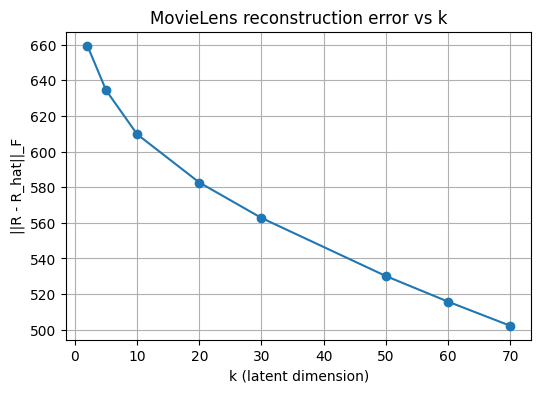

In [ ]:
# -----------------------------
# Interpret, predict, error vs k
# -----------------------------
def frob_error(A, B):
    return norm(A - B, ord="fro")

k_values = [2, 5, 10, 20, 30, 50, 60, 70]
errors = []

for k in k_values:
    Uk, Sigma_k, Vtk, s_all = truncated_svd(R_mat, k)
    R_hat = reconstruct_from_svd(Uk, Sigma_k, Vtk)

    err = frob_error(R_mat, R_hat)
    errors.append((k, err))

    print(f"k={k:2d} -> Reconstruction error: {err:.4f}")

# Plot reconstruction error
plt.figure(figsize=(6, 4))
plt.plot([k for k, _ in errors], [e for _, e in errors], marker="o")
plt.xlabel("k (latent dimension)")
plt.ylabel("||R - R_hat||_F")
plt.title("MovieLens reconstruction error vs k")
plt.grid(True)
plt.show()

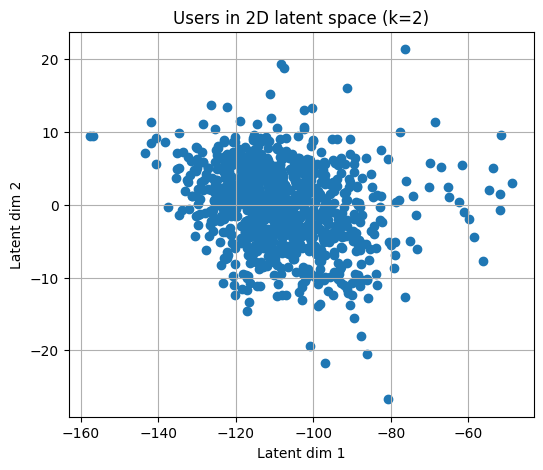

In [ ]:
# -----------------------------
# 7) Visualize latent representations in 2D
# -----------------------------
# Pick k=2 for easy 2D plotting
k = 2
Uk, Sigma_k, Vtk, _ = truncated_svd(R_mat, k)

# Latent user vectors: Uk * Sigma_k (common convention)
user_latent = Uk @ Sigma_k  # shape (m, k)

plt.figure(figsize=(6, 5))
plt.scatter(user_latent[:, 0], user_latent[:, 1])
plt.title("Users in 2D latent space (k=2)")
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.grid(True)
plt.show()


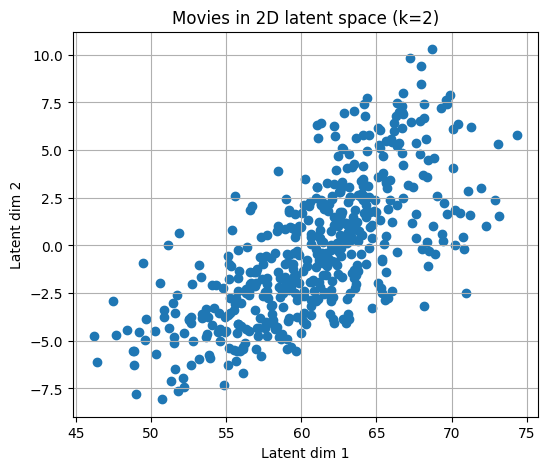

In [ ]:
# Latent movie vectors: V_k * Sigma_k
# Vtk is (k, n) so V_k is transpose
movie_latent = (Sigma_k @ Vtk).T  # shape (n, k)

plt.figure(figsize=(6, 5))
plt.scatter(movie_latent[:, 0], movie_latent[:, 1])
plt.title("Movies in 2D latent space (k=2)")
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.grid(True)
plt.show()